In [2]:
import numpy as np 
import pandas as pd
from pandas import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
suburbs = []
subs = open('areas.txt', 'r')
for line in subs:
    line = line.replace('(', '')
    line = line.replace(')', '')
    line = line.strip()
    suburbs.append(line)
subs.close
print(suburbs)

['Aadhar Multispeciality Hospital, Narhe Pune', 'Anmol Multispeciality Clinic Hospital', 'ANUJA HOSPITAL', 'Bharati Hospital', 'City Care Hospital', 'City Hospital', 'Gawali Hospital', 'jalore hospital', 'Jeevan Uday Multispeciality Hospital', 'Khetmalas Hospital', 'KHETMALAS Hospital1', 'Lifeline Hospital', 'Mai Mangeshkar Hospital', 'Manas Hospital', 'MINERVA HOSPITAL', 'Mixis Multi Specialty Hospital', 'Nagare Nursing Home', 'Nanded Multispeciality Hospital', 'PATIL MULTISPECIALITY HOSPITAL AND LAPROSCOPY CENTER', 'Pune Medical and Research', 'Royal Hospital', 'Sai Sneh Hospital and Diagnostic Center', 'sanjivani hospital', 'Sharayu Multispeciality Hospital', 'SHIVNERI HOSPITAL', 'Shraddha Hospitals', 'SHREE HOSPITAL, NARHE, PUNE', 'Shreeyash Multi-speciality Hospital', 'Shrimangal hospital', 'Shwas Multispeciality Hospital', 'Siddhivinayak General Hospital', 'SILVER BIRCH MULTISPECIALITY HOSPITAL PVT.LTD', 'Sinhagad Speciality Hospital', 'Thube Nursing Home', 'VIGHNAHARTA HOSPITAL'

In [3]:
filenames = []
for i in range(0, len(suburbs)):
  filenames.append("./Reviews/"+str(suburbs[i])+"/reviews.csv")
  # filenames = [
  #             "./Reviews/ANUJA HOSPITAL/reviews.csv",
  #           ]

# merging two csv files
df = pd.concat(
    map(pd.read_csv, filenames), ignore_index=True)

print(len(df))
df

3716


,Rating,Review
0,5 stars,Best Multispecialty hospital in narhe near sin...
1,1 star,Not good hospital. Very very very much waiting...
2,1 star,Our patient got discharge 2 days before i expi...
3,5 stars,As a Surgeon I will always recommend Aadhar Mu...
4,5 stars,I am very frequent visitor to this hospital f...
...,...,...
3711,5 stars,None
3712,5 stars,None
3713,5 stars,None
3714,5 stars,None


In [4]:
review_remove_translated = []

reviews_dict = df.to_dict('list')

for review in reviews_dict['Review']:
  review_sep = str(review).split("(Translated by Google) ")
  
  # Jika terdapat (Translated by Google)
  if review_sep[0] == "":
    review_sep = ("".join(review_sep)).split("(Original)")
    review_sep = review_sep[0]
    review = "".join(review_sep)
  
  review_remove_translated.append(review)

In [5]:
reviews_dict['Review'] = review_remove_translated
df = pd.DataFrame(reviews_dict)
df

,Rating,Review
0,5 stars,Best Multispecialty hospital in narhe near sin...
1,1 star,Not good hospital. Very very very much waiting...
2,1 star,Our patient got discharge 2 days before i expi...
3,5 stars,As a Surgeon I will always recommend Aadhar Mu...
4,5 stars,I am very frequent visitor to this hospital f...
...,...,...
3711,5 stars,None
3712,5 stars,None
3713,5 stars,None
3714,5 stars,None


In [6]:
import string
import re

In [7]:
def clean_review(review):
    return re.sub('[^a-zA-Z]', ' ', review).lower()
  
df['cleaned_review'] = df['Review'].apply(lambda x: clean_review(str(x)))
df['label'] = df['Rating'].map({"1 star":0, "2 stars":0, "3 stars":0, "4 stars":1, "5 stars":1})

In [8]:
def count_punct(review):
    count = sum([1 for char in review if char in string.punctuation])
    return round(count/(len(review) - review.count(" ")), 3)*100
  
df['review_len'] = df['Review'].apply(lambda x: len(str(x)) - str(x).count(" "))
df['punct'] = df['Review'].apply(lambda x: count_punct(str(x)))
df

,Rating,Review,cleaned_review,label,review_len,punct
0,5 stars,Best Multispecialty hospital in narhe near sin...,best multispecialty hospital in narhe near sin...,1,332,2.4
1,1 star,Not good hospital. Very very very much waiting...,not good hospital very very very much waiting...,0,224,3.6
2,1 star,Our patient got discharge 2 days before i expi...,our patient got discharge days before i expi...,0,394,2.8
3,5 stars,As a Surgeon I will always recommend Aadhar Mu...,as a surgeon i will always recommend aadhar mu...,1,319,5.3
4,5 stars,I am very frequent visitor to this hospital f...,i am very frequent visitor to this hospital f...,1,167,4.8
...,...,...,...,...,...,...
3711,5 stars,None,none,1,4,0.0
3712,5 stars,None,none,1,4,0.0
3713,5 stars,None,none,1,4,0.0
3714,5 stars,None,none,1,4,0.0


In [9]:
def tokenize_review(review):
    tokenized_review = review.split()
    return tokenized_review
  
df['tokens'] = df['cleaned_review'].apply(lambda x: tokenize_review(x))
df.head()

,Rating,Review,cleaned_review,label,review_len,punct,tokens
0,5 stars,Best Multispecialty hospital in narhe near sin...,best multispecialty hospital in narhe near sin...,1,332,2.4,"[best, multispecialty, hospital, in, narhe, ne..."
1,1 star,Not good hospital. Very very very much waiting...,not good hospital very very very much waiting...,0,224,3.6,"[not, good, hospital, very, very, very, much, ..."
2,1 star,Our patient got discharge 2 days before i expi...,our patient got discharge days before i expi...,0,394,2.8,"[our, patient, got, discharge, days, before, i..."
3,5 stars,As a Surgeon I will always recommend Aadhar Mu...,as a surgeon i will always recommend aadhar mu...,1,319,5.3,"[as, a, surgeon, i, will, always, recommend, a..."
4,5 stars,I am very frequent visitor to this hospital f...,i am very frequent visitor to this hospital f...,1,167,4.8,"[i, am, very, frequent, visitor, to, this, hos..."


In [10]:
import nltk
from nltk.corpus import stopwords
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

In [11]:
def lemmatize_review(token_list):
    return " ".join([lemmatizer.lemmatize(token) for token in token_list if not token in set(all_stopwords)])

lemmatizer = nltk.stem.WordNetLemmatizer()
df['lemmatized_review'] = df['tokens'].apply(lambda x: lemmatize_review(x))
df.head()

,Rating,Review,cleaned_review,label,review_len,punct,tokens,lemmatized_review
0,5 stars,Best Multispecialty hospital in narhe near sin...,best multispecialty hospital in narhe near sin...,1,332,2.4,"[best, multispecialty, hospital, in, narhe, ne...",best multispecialty hospital narhe near sinhga...
1,1 star,Not good hospital. Very very very much waiting...,not good hospital very very very much waiting...,0,224,3.6,"[not, good, hospital, very, very, very, much, ...",not good hospital much waiting report collecti...
2,1 star,Our patient got discharge 2 days before i expi...,our patient got discharge days before i expi...,0,394,2.8,"[our, patient, got, discharge, days, before, i...",patient got discharge day expirienced followin...
3,5 stars,As a Surgeon I will always recommend Aadhar Mu...,as a surgeon i will always recommend aadhar mu...,1,319,5.3,"[as, a, surgeon, i, will, always, recommend, a...",surgeon always recommend aadhar multispecialty...
4,5 stars,I am very frequent visitor to this hospital f...,i am very frequent visitor to this hospital f...,1,167,4.8,"[i, am, very, frequent, visitor, to, this, hos...",frequent visitor hospital wife treatment docto...


In [12]:
#  Shape of the dataset, and breakdown of the classes
print(f"Input data has { len(df) } rows and { len(df.columns) } columns")

Input data has 3716 rows and 8 columns


Number of null in label: 0
Number of null in text: 0


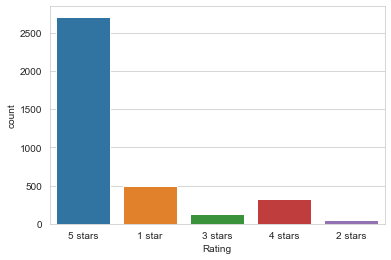

In [13]:
print(f"Number of null in label: { df['Rating'].isnull().sum() }")
print(f"Number of null in text: { df['Review'].isnull().sum() }")
sns.countplot(x='Rating', data=df);

In [14]:
X = df[['lemmatized_review', 'review_len', 'punct']]
y = df['label']
print(X.shape)
print(y.shape)

(3716, 3)
(3716,)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2601, 3)
(1115, 3)
(2601,)
(1115,)


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df = 0.5, min_df = 2) # ignore terms that occur in more than 50% documents and the ones that occur in less than 2
tfidf_train = tfidf.fit_transform(X_train['lemmatized_review'])
tfidf_test = tfidf.transform(X_test['lemmatized_review'])

X_train_vect = pd.concat([X_train[['review_len', 'punct']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['review_len', 'punct']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,review_len,punct,0,1,2,3,4,5,6,7,...,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844
0,79,10.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

              precision    recall  f1-score   support

           0       0.96      0.50      0.65       204
           1       0.90      1.00      0.94       911

    accuracy                           0.90      1115
   macro avg       0.93      0.75      0.80      1115
weighted avg       0.91      0.90      0.89      1115



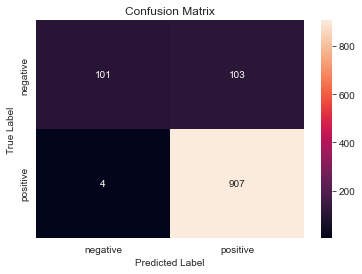

In [18]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train_vect, y_train)
naive_bayes_pred = classifier.predict(X_test_vect)

# Classification Report
print(classification_report(y_test, naive_bayes_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, naive_bayes_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.50      0.66       204
           1       0.90      1.00      0.95       911

    accuracy                           0.91      1115
   macro avg       0.94      0.75      0.80      1115
weighted avg       0.91      0.91      0.89      1115



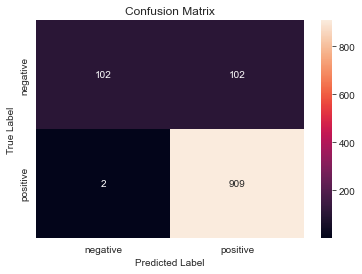

In [19]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train_vect, y_train)
log_reg_pred = classifier.predict(X_test_vect)
# Classification report
print(classification_report(y_test, log_reg_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, log_reg_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.58      0.72       204
           1       0.91      0.99      0.95       911

    accuracy                           0.92      1115
   macro avg       0.92      0.79      0.83      1115
weighted avg       0.92      0.92      0.91      1115



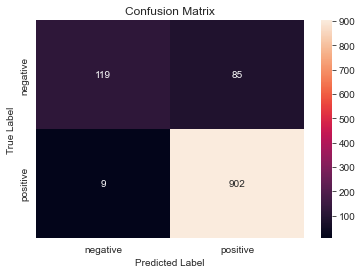

In [35]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train_vect, y_train)
svm_pred = classifier.predict(X_test_vect)
# Classification report
print(classification_report(y_test, svm_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, svm_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.46      0.10      0.17       204
           1       0.83      0.97      0.89       911

    accuracy                           0.81      1115
   macro avg       0.64      0.54      0.53      1115
weighted avg       0.76      0.81      0.76      1115



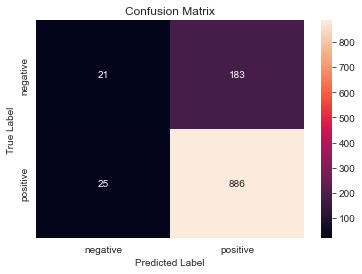

In [20]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(X_train_vect, y_train)
knn_pred = classifier.predict(X_test_vect)

# Classification report
print(classification_report(y_test, knn_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, knn_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

models = [
          MultinomialNB(),
          LogisticRegression(),
          SVC(kernel = 'linear'),
          KNeighborsClassifier(n_neighbors = 5),
         ]
names = ["Naive Bayes", "Logistic Regression", "SVM", "KNN"]
for model, name in zip(models, names):
    print(name)
    for score in ["accuracy", "precision", "recall", "f1"]:
        print(f" {score} - {cross_val_score(model, X_train_vect, y_train, scoring=score, cv=10).mean()} ")
    print()

In [36]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 10)
# from sklearn.ensemble import ExtraTreesClassifier
# classifier = ExtraTreesClassifier(n_estimators=150, random_state=50)

classifier.fit(tfidf_train, y_train)
classifier.score(tfidf_test, y_test)

0.9174887892376682

In [39]:
data = ["Bad", "Good", "I love the service, it's really good", "Worst"]
vect = tfidf.transform(data).toarray()

my_pred = classifier.predict(vect)
print(my_pred)

[0 1 1 0]


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_cv = cv.fit_transform(df['lemmatized_review']) # Fit the Data
y_cv = df['label']

from sklearn.model_selection import train_test_split
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv, y_cv, test_size=0.3, random_state=42)

In [41]:
#Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

clf.fit(X_train_cv, y_train_cv)
clf.score(X_test_cv, y_test_cv)


0.915695067264574

In [42]:
data = ["Bad", "Worst service, don't go there", "Services are OK", "Good service", "The nurse is so kind"]
vect = cv.transform(data).toarray()

my_prediction = clf.predict(vect)
print(my_prediction)

[0 0 1 1 1]


In [3]:
def calculate_distance():

        lat = float(input("Enter your latitude: "))
        lon = float(input("Enter your longitude: "))

        ran = float(input("Enter the range(in km): ")) #in km

        change_per_deg_lat = 111.2
        change_per_deg_long = 105.75

        df = pd.read_csv("modified.csv")

        for row in df.itertuples():

                x = abs(float(row[6]) - lon) * change_per_deg_long
                y = abs(float(row[5]) - lat) * change_per_deg_lat
                dist = (x**2 + y**2)**(1/2)

                if dist <= ran:
                        print(row[1])

        return row

calculate_distance()

Suyash Hospital
Shree surgical and general Hospital Kothrud
Orchids Hospital
Shifa Clinic
hospital
Chavhan Hospital
Dhanwantari Hospital
Kulkarni Hospital
Lopmudra Hospital
Pashan Hospital Pmc
Late Sahadeo Eknath Nimhan Dispensary
Samarth Hospital
Om Hospital- General Laparoscopic Surgeon | Orthopaedic Surgeon | Hospital in Shivaji nagar, Pune
Jeevan Hospital
Lokmanya Hospital For Special Surgery (LHSS)
IVAA Multi-Speciality Hospital
Dedicate Covid Hospital
Jupiter Hospital, Pune
Shashwat Hospital Aundh
Unity Hospital
Sancheti Hospital
Aundh Institute of Medical Sciences
Umarji Mother and Child Care Hospital(उमरजी माता आणि लहान मुलांचे रुग्णालय)
SPPU Health Centre
Sunshine Multispeciality Hospital
ACCORD
Benecare Hospital - Best Maternity Hospital | IVF Center in Pune
Urokul Hospital
Pratiti Hospital
Manipal Hospitals Baner
Shree Tvak
Kotbagi Hospital
AIMS HOSPITAL AND RESEARCH CENTER
Lokmanya Hospital Aundh
Accident Fracture Care
Unity Hospital
Utility Hospital
Aundh Kuti Hospital
Shr

Pandas(Index=787, Name='Mangesh Hospital and Nursing Home', _2="('18.6426779', '74.0519118')", Rating='5.0(8)', Info='Hospital · J3R2+5FW\r\nOpen 24 hours', Latitude=18.6426779, Longitude=74.0519118, Ratings='5', Type_hospital='Hospital', Address_Contact=' J3R2+5FW\r\nOpen 24 hours', Number_of_Ratings='8')

In [34]:
process = read_csv("./Reviews/Sancheti Hospital/reviews.csv")
data = process['Review'].to_list()
vect = cv.transform(data).toarray()

my_prediction = clf.predict(vect)
flag = "Bad"
zeroes = len(my_prediction) - np.count_nonzero(my_prediction)
if np.count_nonzero(my_prediction) > zeroes:
    flag = "Good"
# print(my_prediction)
# print(zeroes)
# print(np.count_nonzero(my_prediction))
print(flag)

Good


In [44]:
list_hosp = calculate_distance()
#18.4491376
#73.8760855
print(list_hosp)
for x in list_hosp:
    if x in suburbs & x != "None":
        process = read_csv("./Reviews/"+str(x)+"/reviews.csv")
        data = process['Review'].to_list()
        vect = cv.transform(data).toarray()

        my_prediction = clf.predict(vect)
        flag = "Bad"
        zeroes = len(my_prediction) - np.count_nonzero(my_prediction)
        if np.count_nonzero(my_prediction) > zeroes:
            flag = "Good"
        print(my_prediction)
        print(zeroes)
        print(np.count_nonzero(my_prediction))
        print(flag)

SHREE HOSPITAL, NARHE, PUNE
Shwas Multispeciality Hospital
sanjivani hospital
Manas Hospital
PATIL MULTSPECIALITY HOSPITAL AND LAPROSCOPY CENTER
Shivprasad Hospital
Royal Hospital
Mauli Clinic
Khetmalas Hospital
AAI HOSPITAL
SHIVNERI HOSPITAL. C-1 Building, Manik Moti Co-operative Housing Society, Sr. No. 84, More Baug, Katraj, Pune.
City Care Hospital
Pune Medical and Research
Sai Sneh Hospital and Diagnostic Center
Bharati Hospital
KHETMALAS Hospital
Gawali Hospital
Mixis Multi Specialty Hospital
Siddhivinayak Multi Speciality Hospital
Srishti Hospital
Vasant More Hospital
Dr. Masal Hospital
Gupta House & Hospital
Hospital
Satyanand Hospital - Best Elderly Care In Pune
Global Health Care Hospital
Lifeline Hospital
Sangam Hospital - Undri
NIRVANA HOSPITAL
Precision Plus Superspeciality Hospital | Best Hospital in Undri, Hadapsar, Pune
Kalpataru Hospital, Undri. Day care
Athang Multispecialty Clinic
Anand Hospital
Athang Multispeciality Clinic
Samarth Nursing Home
Tejpal Hospital
Vimal

TypeError: unsupported operand type(s) for &: 'list' and 'int'